DBSCAN Clustering results on daily shot patterns:
          Date  NumShots  SuccessRate  NumSuccesses  NumMisses  Cluster
0   2020-06-17        88     0.568182          50.0       38.0       -1
1   2020-06-18       350     0.708571         248.0      102.0       -1
2   2020-06-19       407     0.719902         293.0      114.0        1
3   2020-06-20       443     0.742664         329.0      114.0        1
4   2020-06-21       585     0.738462         432.0      153.0       -1
5   2020-06-22       548     0.686131         376.0      172.0       -1
6   2020-06-23       450     0.668889         301.0      149.0       -1
7   2020-06-24       300     0.690000         207.0       93.0       -1
8   2020-06-25       306     0.732026         224.0       82.0        0
9   2020-06-26       100     0.760000          76.0       24.0       -1
10  2020-06-27       495     0.737374         365.0      130.0        1
11  2020-06-28       227     0.779736         177.0       50.0       -1
12  2020-06-29

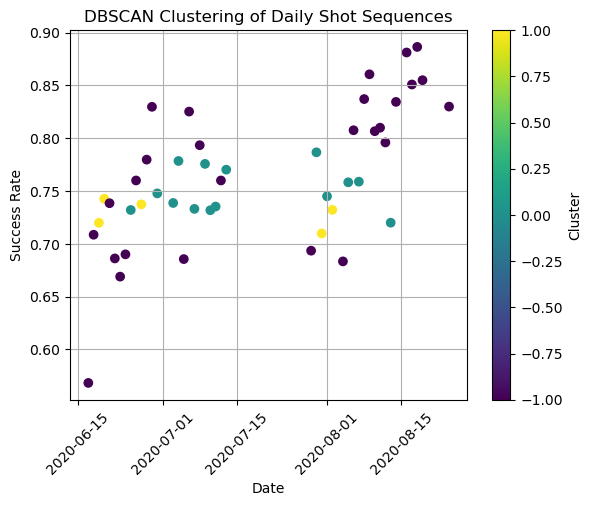

In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Step 1: טעינת הנתונים
file_path = r"C:\Users\guymk\Downloads\data13 (1).csv"  # נתיב לקובץ שלך
data_cleaned = pd.read_csv(file_path)

# Step 2: יצירת פונקציה לניקוי והמרת התאריכים בפורמט ידני מתוך המחרוזות
def extract_datetime(text):
    try:
        # חיפוש תאריך ושעה בעזרת Regex
        match = re.search(r'\w+ \w+ \d+ \d+ \d+:\d+:\d+', text)
        if match:
            return pd.to_datetime(match.group(0))
        else:
            return pd.NaT  # אם לא נמצא תאריך, מחזירים NaT
    except Exception as e:
        return pd.NaT

# Step 3: המרת העמודה Unnamed: 1 בעזרת הפונקציה הידנית
data_cleaned['HitLocalTime'] = data_cleaned['Unnamed: 1'].apply(extract_datetime)

# Step 4: הוספת עמודת תאריך כדי שנוכל לקבץ את הזריקות לפי יום
data_cleaned['Date'] = data_cleaned['HitLocalTime'].dt.date

# Step 5: המרת העמודה 'Made' למספרית: TRUE = 1, FALSE = 0
data_cleaned['MadeNumeric'] = data_cleaned['Unnamed: 7'].map({'TRUE': 1, 'FALSE': 0})

# Step 6: יצירת מאפייני רצף יומיים: מספר זריקות ביום, אחוזי הצלחה, מספר הצלחות והחטאות ביום
daily_features = data_cleaned.groupby('Date').agg(
    NumShots=('MadeNumeric', 'count'),
    SuccessRate=('MadeNumeric', 'mean'),
    NumSuccesses=('MadeNumeric', 'sum'),
    NumMisses=('MadeNumeric', lambda x: (1 - x).sum())
).reset_index()

# Step 7: מילוי ערכים חסרים (אם יש) ב-0
daily_features = daily_features.fillna(0)

# Step 8: ביצוע קלאסטרינג עם DBSCAN
if not daily_features.empty:
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(daily_features[['SuccessRate', 'NumSuccesses', 'NumMisses']])
    
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    daily_features['Cluster'] = dbscan.fit_predict(X_scaled)
else:
    print("No data available for clustering.")

# Step 9: הצגת התוצאות
if 'Cluster' in daily_features.columns:
    print("DBSCAN Clustering results on daily shot patterns:")
    print(daily_features)

    # Step 10: ויזואליזציה של התוצאות
    plt.scatter(daily_features['Date'], daily_features['SuccessRate'], 
                c=daily_features['Cluster'], cmap='viridis', marker='o')
    plt.title('DBSCAN Clustering of Daily Shot Sequences')
    plt.xlabel('Date')
    plt.ylabel('Success Rate')
    plt.xticks(rotation=45)
    plt.colorbar(label='Cluster')
    plt.grid(True)
    plt.show()
else:
    print("Clustering could not be performed due to lack of data.")
